In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np
from sklearn.manifold import TSNE

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

/home/dlopez/tmp/pip-tmp/ipykernel_411188/550949071.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}


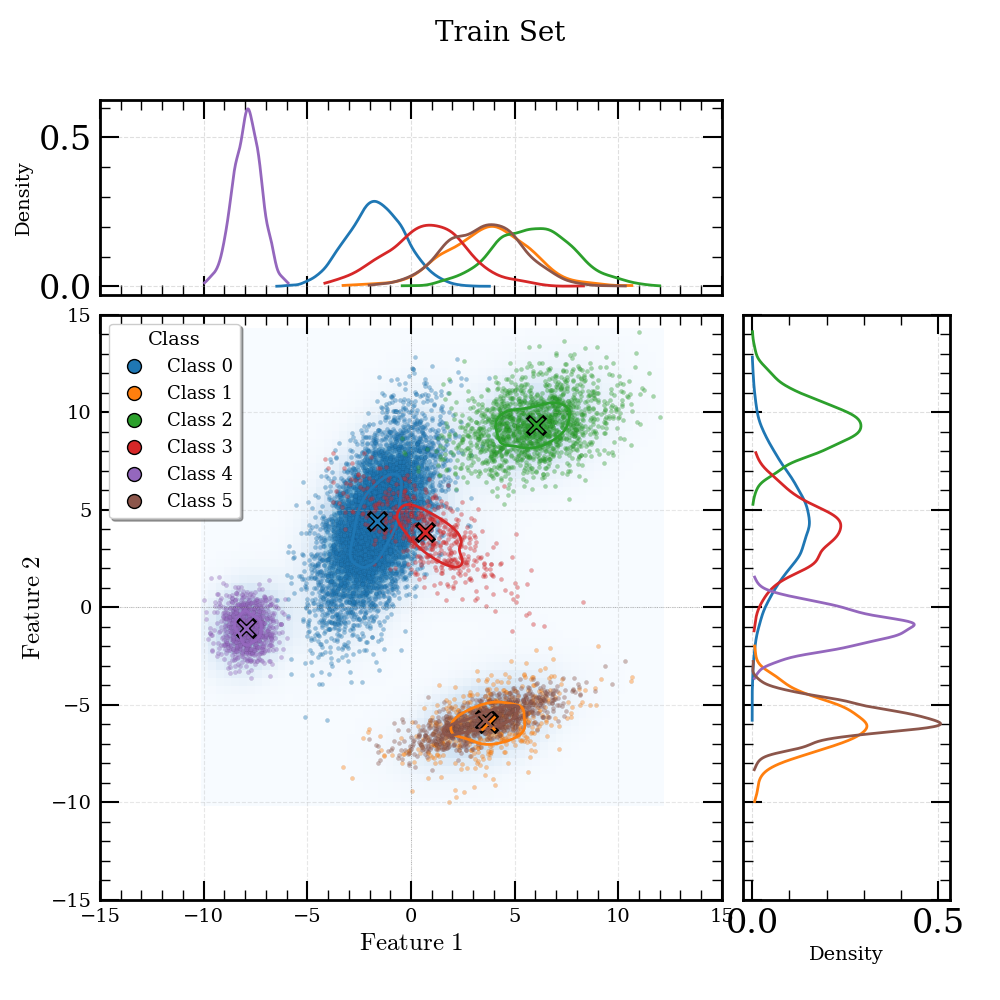

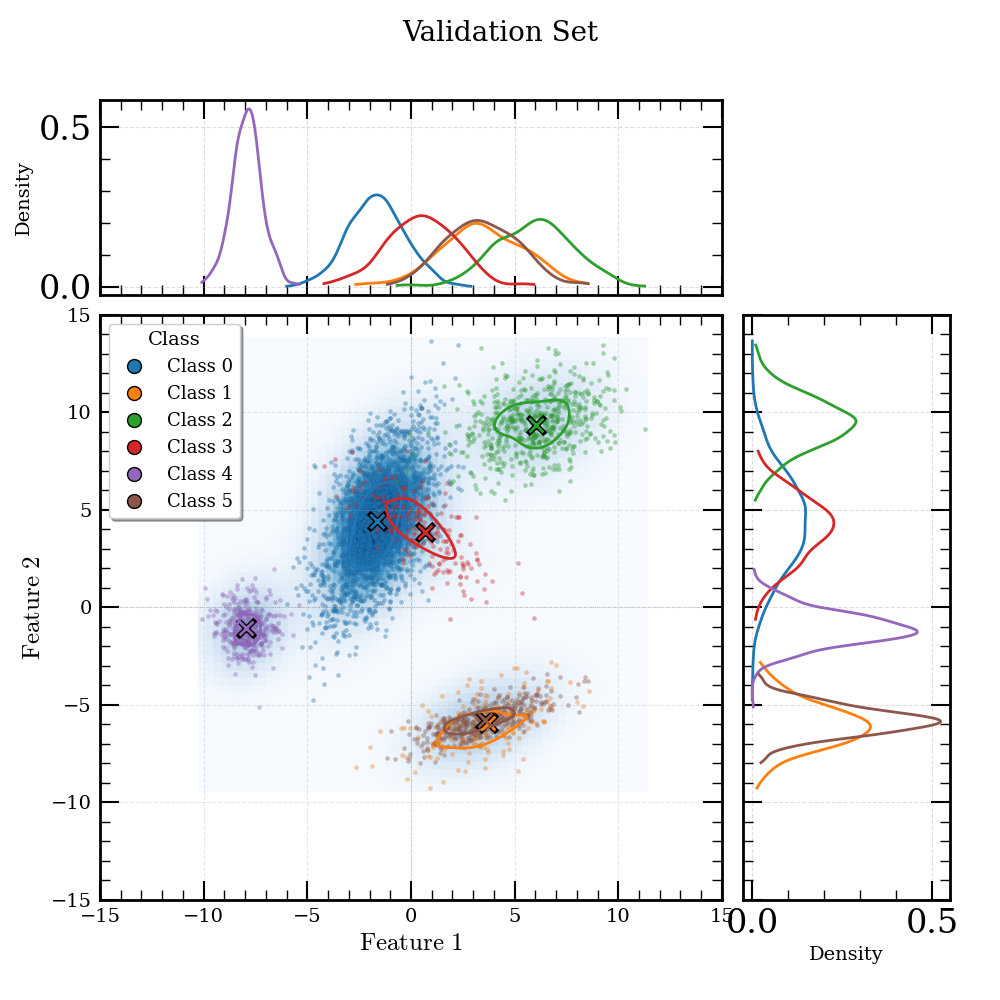

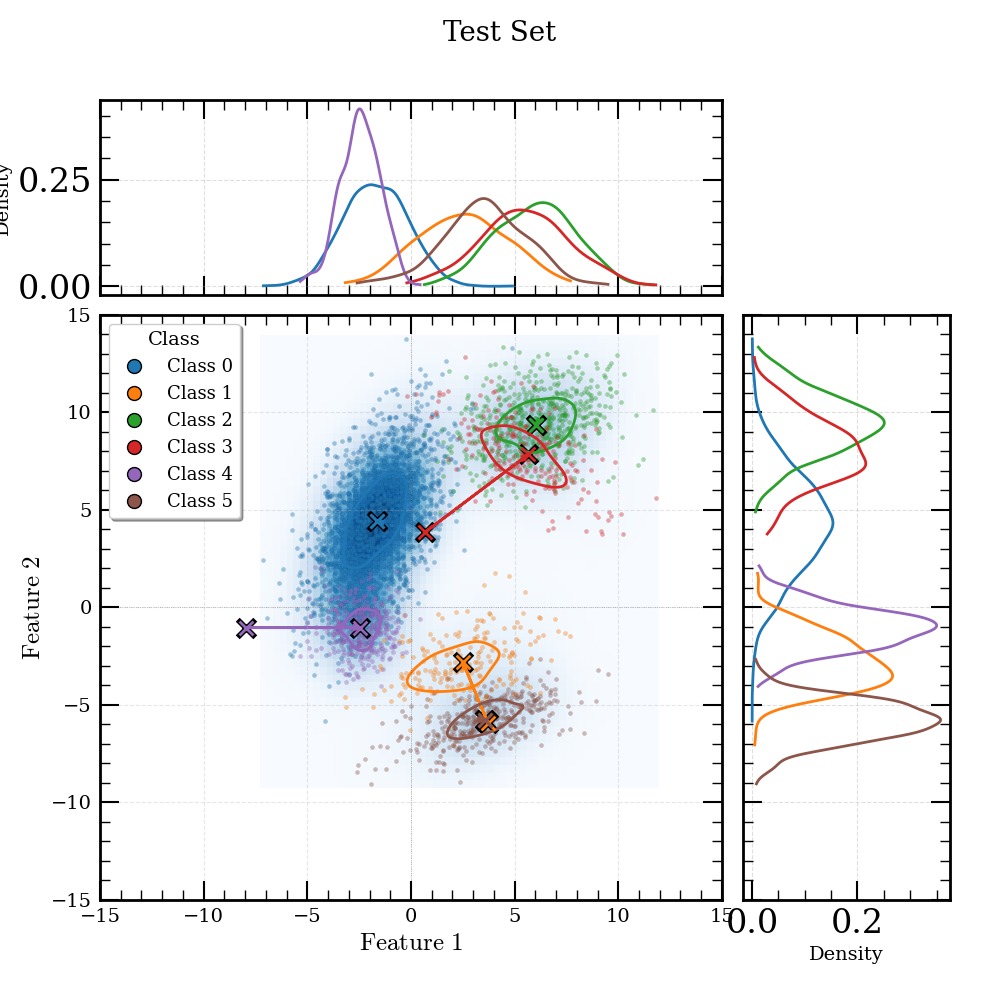

In [2]:
# === Shared Parameters ===
n_classes = 6
n_features = 2
class_center_range = [(-10, 10), (-10, 10)]
cov_scale_range = (0.1, 1.1)
class_proportions = np.array([0.55, 0.05, 0.15, 0.05, 0.1, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# === Sample Sizes and Seeds ===
n_samples_train = 10000
n_samples_val = 4000
n_samples_test = 4000
n_samples_train_DA = 4000
n_samples_val_DA = 4000

seed_structure = 1     # Used to define centers and covariances
seed_train = 42        # Ensures different train/val/test samples
seed_val = 13
seed_test = 0
seed_train_DA = 2
seed_val_DA = 3
seed_shift = 4

# === Generate fixed shared structure for train/val ===
shared_centers, shared_covs = generate_toy_data.generate_centers_covs(n_classes, n_features, class_center_range, cov_scale_range, seed_structure)

# === Generate train/val sets with different seeds but same structure ===
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_structure(n_samples_train, shared_centers, shared_covs, class_proportions, seed=seed_train)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_structure(n_samples_val, shared_centers, shared_covs, class_proportions, seed=seed_val)

# === Generate test set with shifted centers and covs ===
shifted_centers, shifted_covs = generate_toy_data.shift_centers_covs(shared_centers, shared_covs, center_shift=1.0, cov_shift=0.5, seed=seed_shift)

shifted_centers = np.array([
[-1.65955991,  4.40648987],
[ 2.50439001, -2.81095501],
[ 6.01489137,  9.36523151],
[ 5.6633057 ,  7.83754228],
[-2.43547987, -1.04212948],
[ 3.57671066, -5.76743768]
])
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_structure(n_samples_test, shifted_centers, shifted_covs, class_proportions, seed=seed_test)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)


# === Visualize sets ===
color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}

fig1, ax_main1 = plotting_utils.plot_2d_classification_with_kde(xx_train["OBS"], yy_train["SPECTYPE_int"], title="Train Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main1.set_xlim(-15, 15)
ax_main1.set_ylim(-15, 15)
plt.show()

fig2, ax_main2 = plotting_utils.plot_2d_classification_with_kde(xx_val["OBS"], yy_val["SPECTYPE_int"], title="Validation Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main2.set_xlim(-15, 15)
ax_main2.set_ylim(-15, 15)
plt.show()

fig3, ax_main3 = plotting_utils.plot_2d_classification_with_kde(xx_test["OBS"], yy_test["SPECTYPE_int"], title="Test Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    delta = shifted_centers[i] - shared_centers[i]
    ax_main3.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1], color=color_dict[i], linewidth=2, head_width=0.2, length_includes_head=True)
ax_main3.set_xlim(-15, 15)
ax_main3.set_ylim(-15, 15)
plt.show()

In [3]:
path_load_no_DA = os.path.join(global_setup.path_models, "06_example_model")
path_load_DA = os.path.join(global_setup.path_models, "07_example_model_DA")

In [4]:
dset_val_no_DA = data_loaders.DataLoader(xx_val, yy_val)
dset_val_DA = data_loaders.DataLoader(xx_val_DA, yy_val_DA)
dset_test = data_loaders.DataLoader(xx_test, yy_test)

2025-09-18 18:12:23,595 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-18 18:12:23,596 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-09-18 18:12:23,596 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-18 18:12:23,596 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-09-18 18:12:23,597 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-18 18:12:23,597 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]


In [5]:
_, model_encoder_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_, model_encoder_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_ = evaluation_tools.compare_model_parameters(model_downstream_no_DA, model_downstream_DA, rtol=1e-2, atol=1e-2)

✅ All parameters match.


In [6]:
xx, yy_true = dset_val_no_DA(batch_size=dset_val_no_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_no_DA = yy_true.cpu().numpy()
features_val_no_DA = features_.cpu().numpy()
yy_pred_P_val_no_DA = yy_pred_P.cpu().numpy()
yy_pred_val_no_DA = np.argmax(yy_pred_P_val_no_DA, axis=1)


xx, yy_true = dset_val_DA(batch_size=dset_val_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_DA = yy_true.cpu().numpy()
features_val_DA = features_.cpu().numpy()
yy_pred_P_val_DA = yy_pred_P.cpu().numpy()
yy_pred_val_DA = np.argmax(yy_pred_P_val_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_no_DA = features_.cpu().numpy()
yy_pred_P_test_no_DA = yy_pred_P.cpu().numpy()
yy_pred_test_no_DA = np.argmax(yy_pred_P_test_no_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_DA = features_.cpu().numpy()
yy_pred_P_test_DA = yy_pred_P.cpu().numpy()
yy_pred_test_DA = np.argmax(yy_pred_P_test_DA, axis=1)

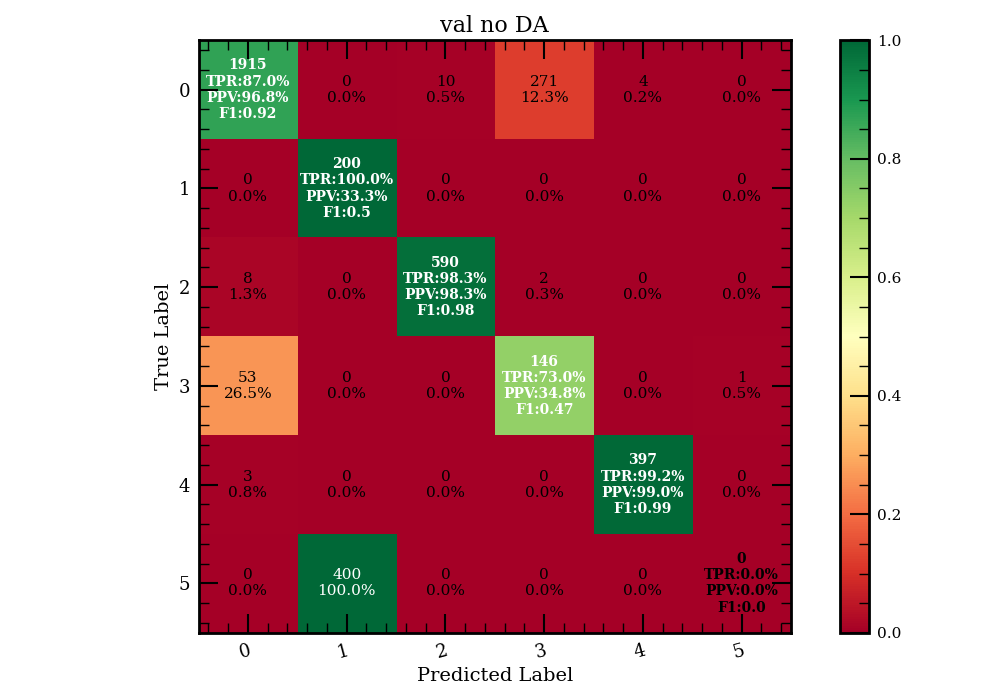

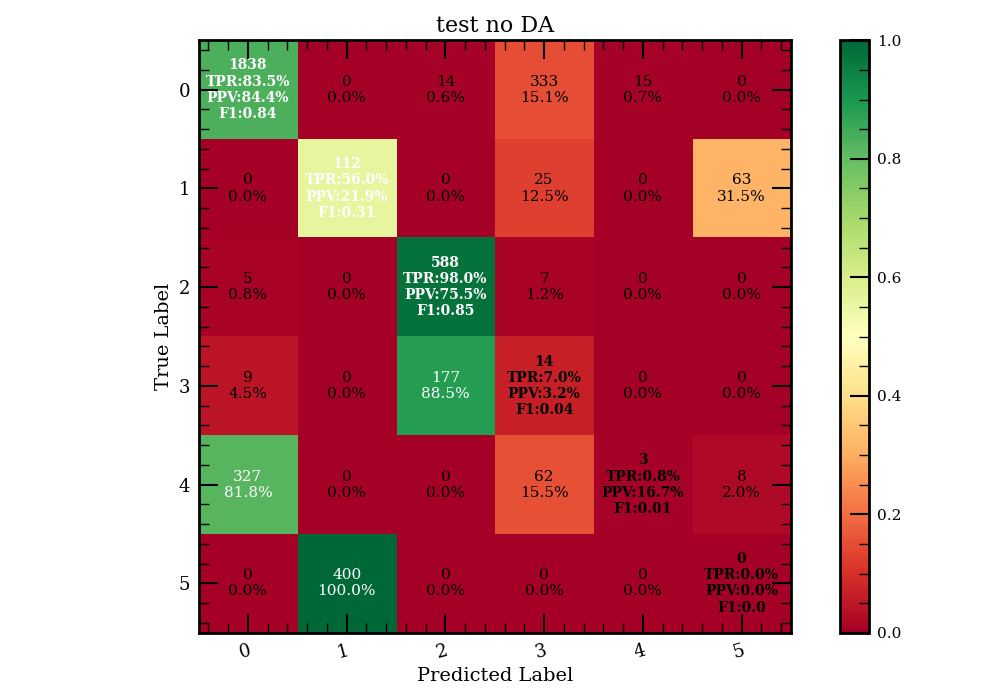

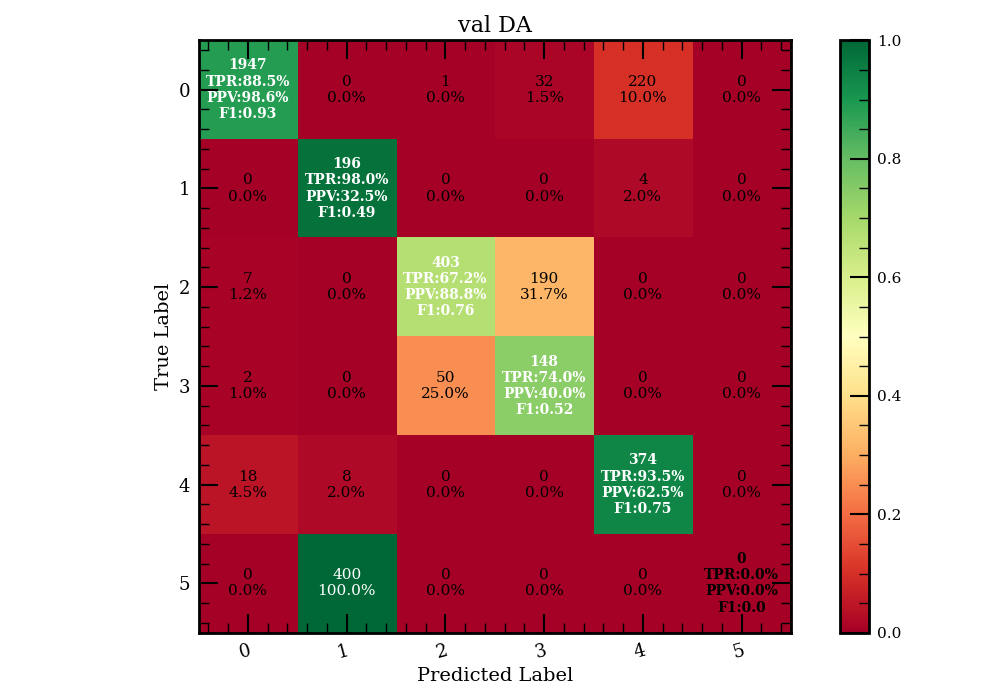

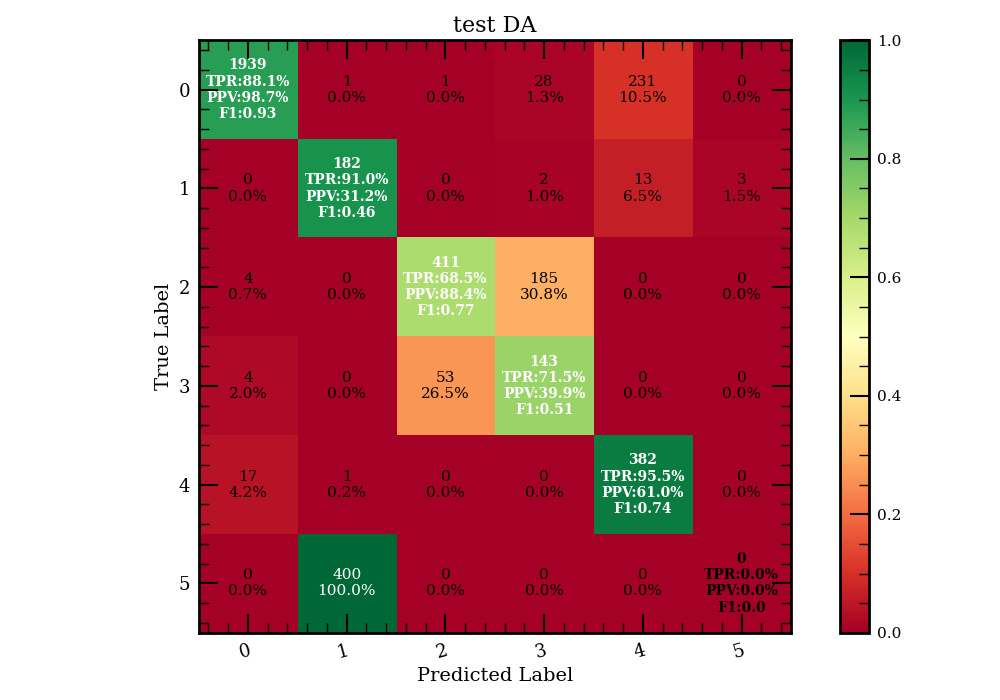

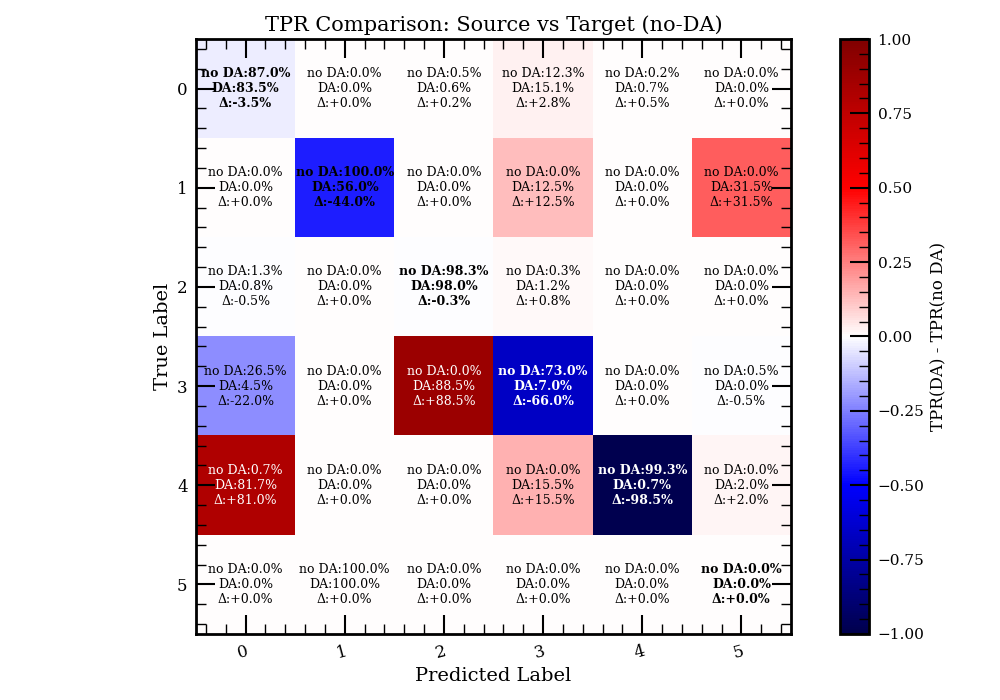

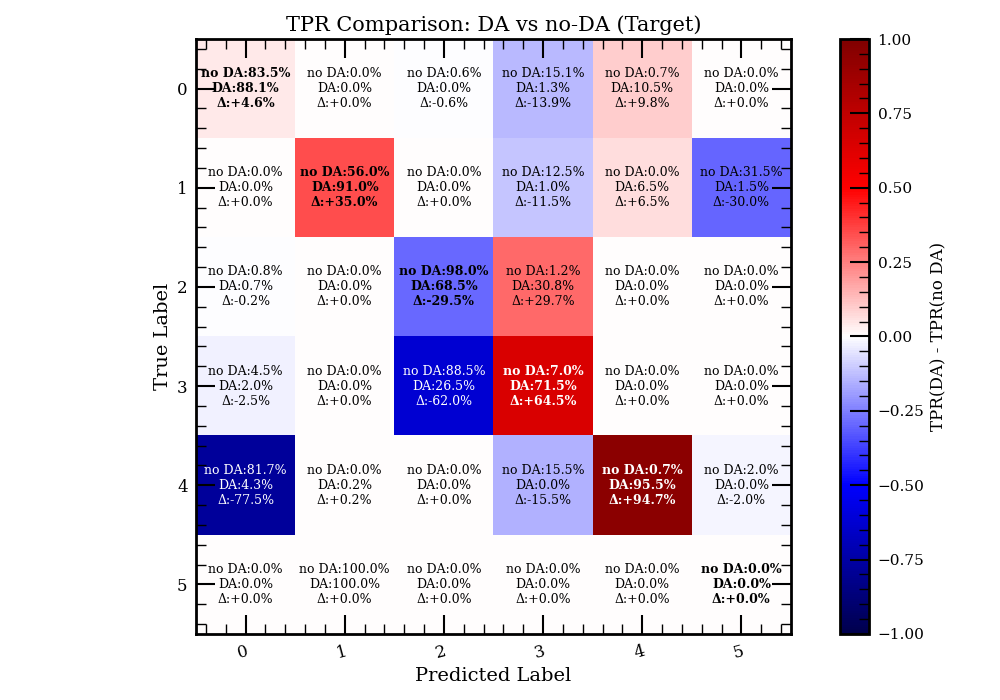

In [7]:
evaluation_tools.plot_confusion_matrix(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val no DA"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test no DA"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_val_DA, yy_pred_P_val_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val DA"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test DA"
)

evaluation_tools.compare_TPR_confusion_matrices(
    yy_true_val_no_DA,
    yy_pred_P_val_no_DA,
    yy_true_test,
    yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: Source vs Target (no-DA)',
    name_1 = "no DA",
    name_2 = "DA"
)
evaluation_tools.compare_TPR_confusion_matrices(
    yy_true_test,
    yy_pred_P_test_no_DA,
    yy_true_test,
    yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: DA vs no-DA (Target)',
    name_1 = "no DA",
    name_2 = "DA"
)


=== Source no-DA vs Target no-DA Metrics ===
Metric                        Source no-DATarget no-DAΔ (Target no-DA - Source no-DA)
-------------------------------------------------------------------------------------
Accuracy                            0.8120      0.6388           -0.1733
Macro F1                            0.6438      0.3441           -0.2997
Macro TPR                           0.7627      0.4088           -0.3539
Macro Precision                     0.6038      0.3359           -0.2679
Macro AUROC                         0.9642      0.8309           -0.1333
Expected Calibration Error          0.0646      0.1393            0.0747
Brier Score                         0.2131      0.4730            0.2599


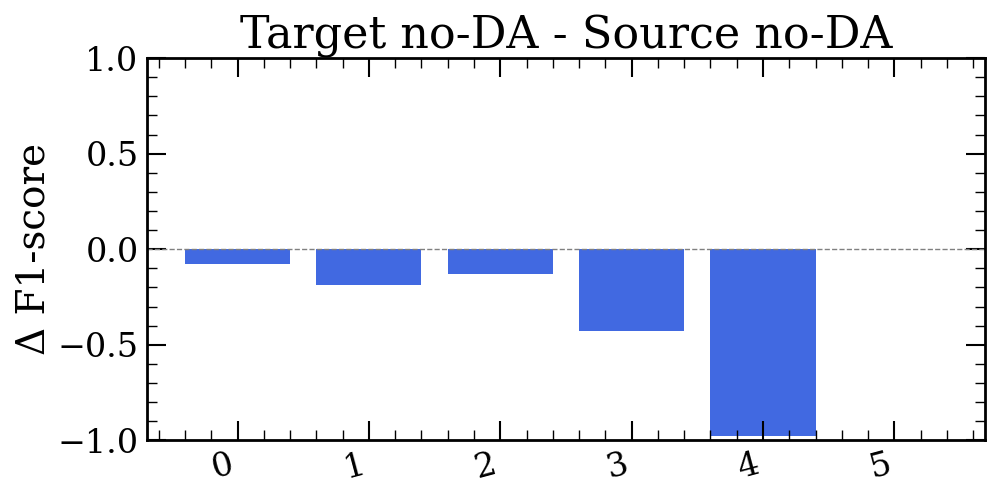

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:593: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


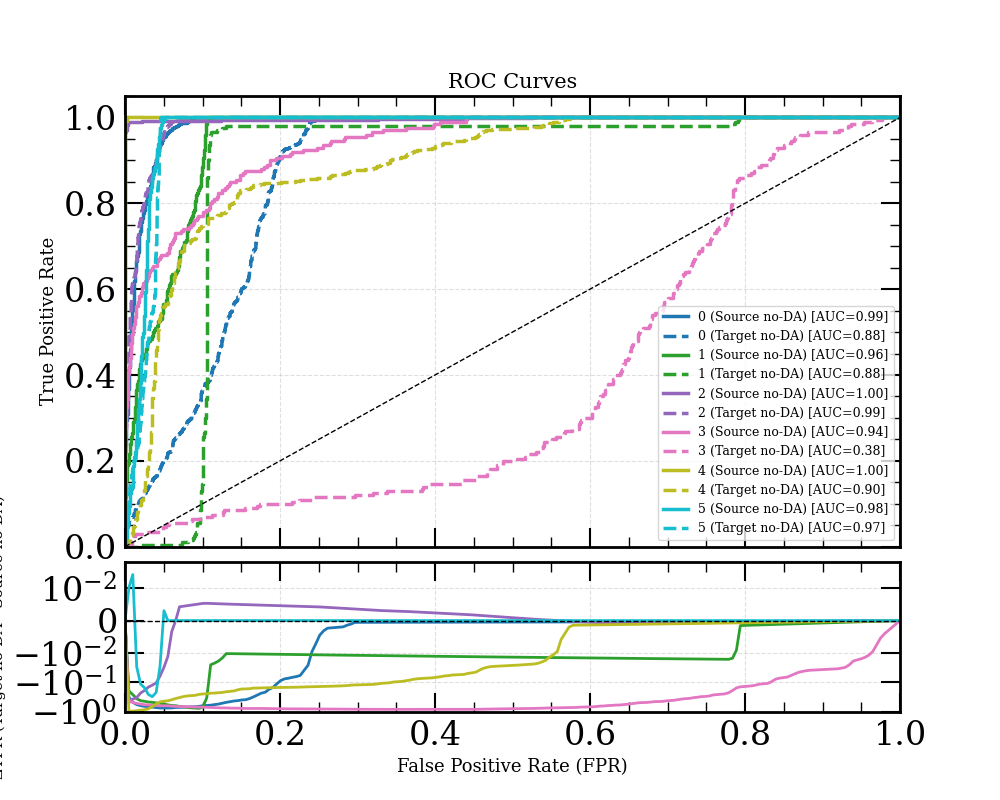


=== no-DA (Target) vs DA Metrics ===
Metric                        no-DA (Target)          DAΔ (DA - no-DA (Target))
-------------------------------------------------------------------------------
Accuracy                            0.6388      0.7642            0.1255
Macro F1                            0.3441      0.5708            0.2266
Macro TPR                           0.4088      0.6911            0.2822
Macro Precision                     0.3359      0.5321            0.1962
Macro AUROC                         0.8309      0.9742            0.1433
Expected Calibration Error          0.1393      0.0549           -0.0845
Brier Score                         0.4730      0.2600           -0.2129


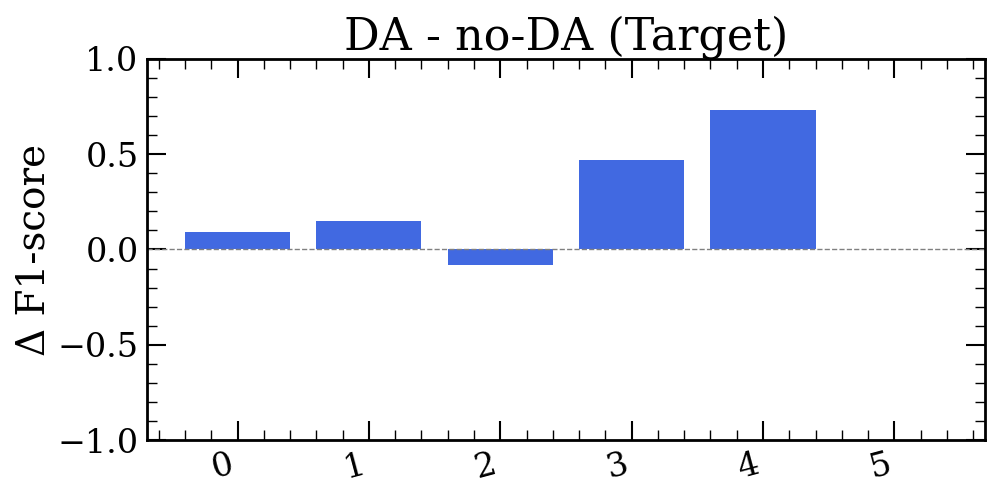

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:593: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


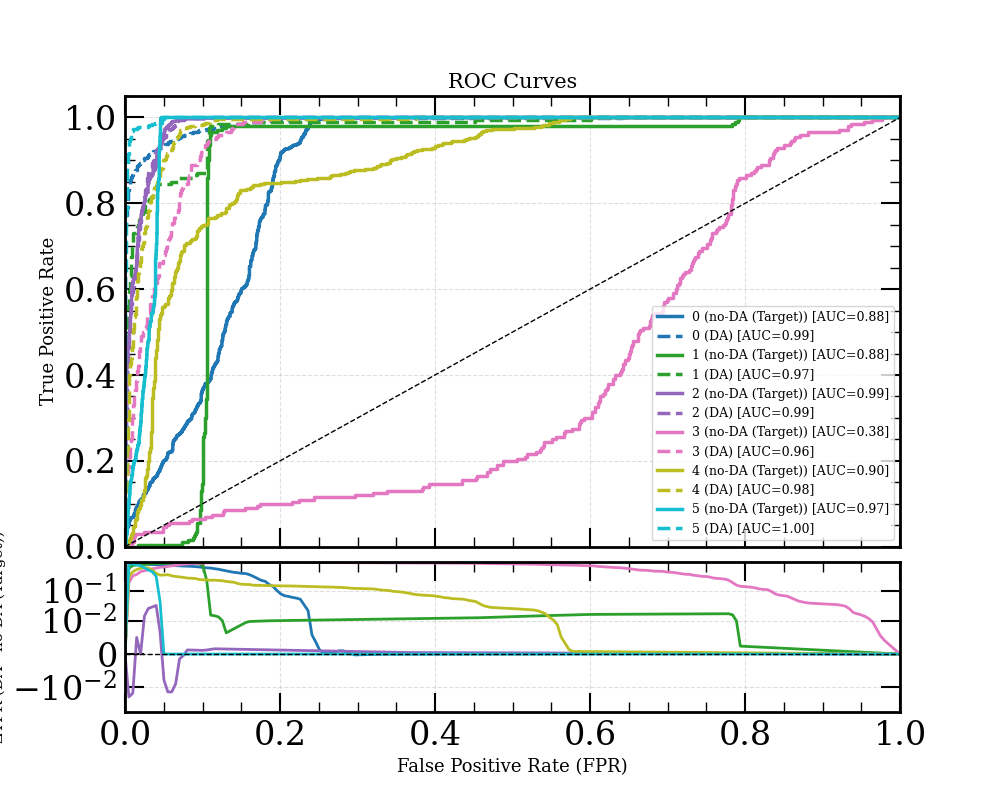

In [8]:
metrics = evaluation_tools.compare_sets_performance(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    name_1="Source no-DA",
    name_2="Target no-DA",
    y_max_Delta_F1=1.0,
    y_min_Delta_F1=-1.0,
)

metrics = evaluation_tools.compare_sets_performance(
    yy_true_test, yy_pred_P_test_no_DA,
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    name_1="no-DA (Target)",
    name_2="DA",
    y_max_Delta_F1=1.0,
    y_min_Delta_F1=-1.0,
)

# Explore latent space

In [9]:
feat_dict = {
    "latents_no_DA_Source": features_val_no_DA,
    "latents_no_DA_Target": features_test_no_DA,
    "latents_DA_Target": features_test_DA
}

latents_tSNE = evaluation_tools.tsne_per_key(
    feat_dict,
    standardize=False,
    subsample=None,
    random_state=137,
    tsne_kwargs={"perplexity": 100},
    return_all_key=None,
)

2025-09-18 18:12:26,839 - INFO - t-SNE on N=12000 (perplexity=100)...


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.002s...
[t-SNE] Computed neighbors for 12000 samples in 0.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.191523
[t-SNE] KL divergenc

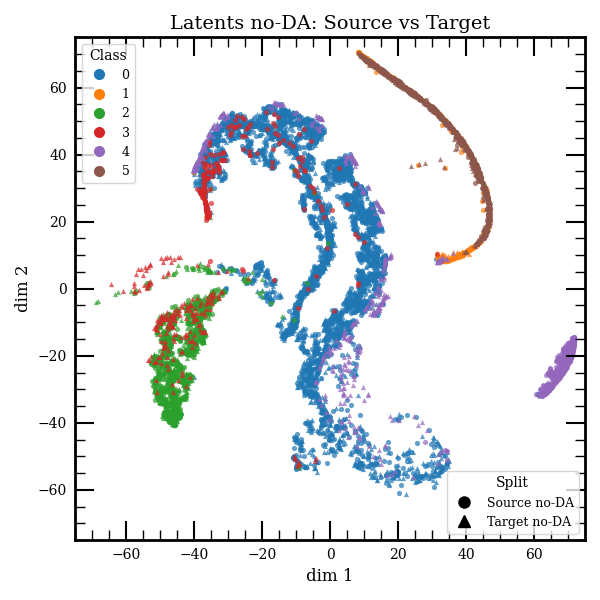

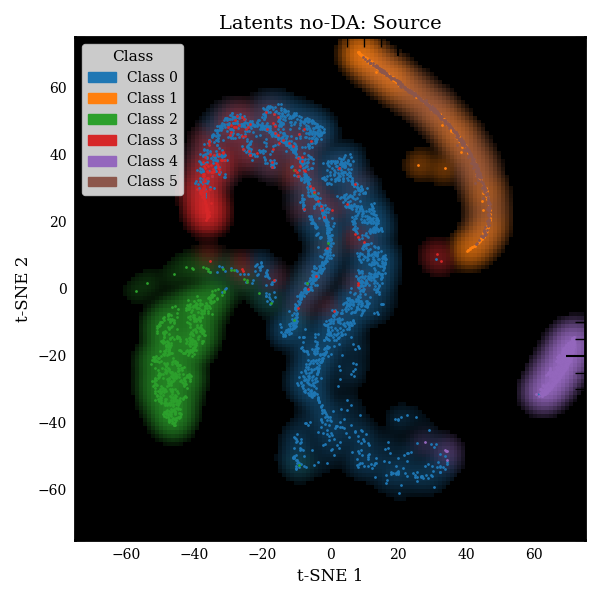

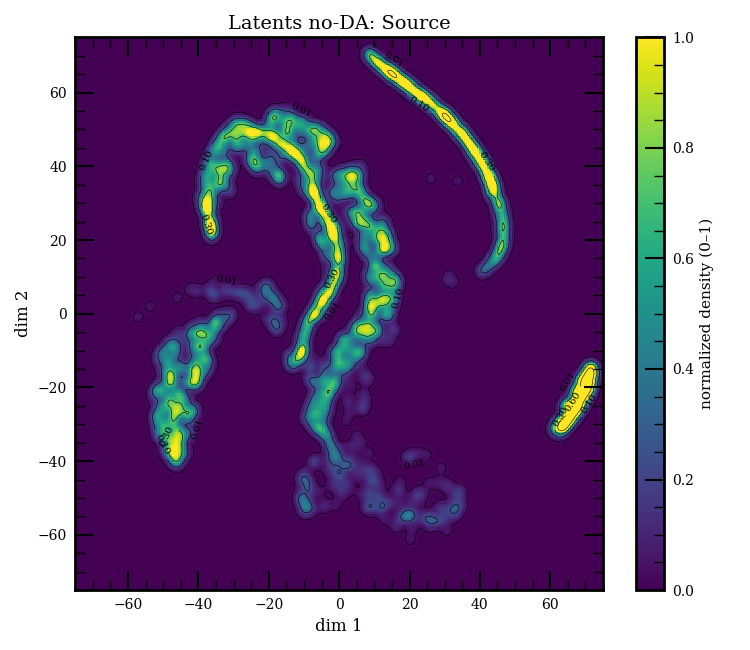

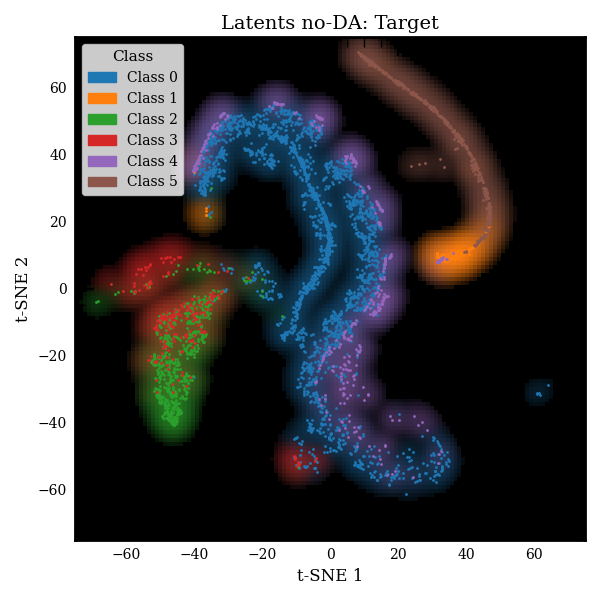

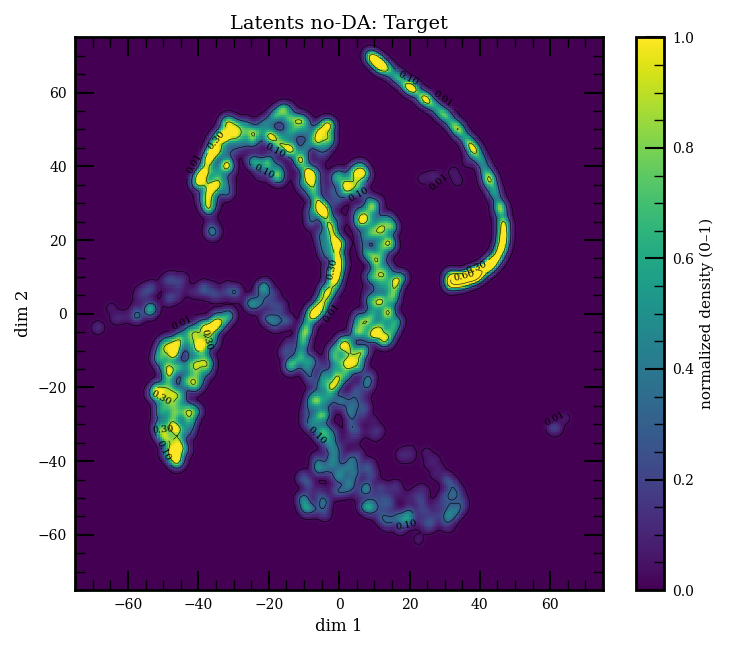

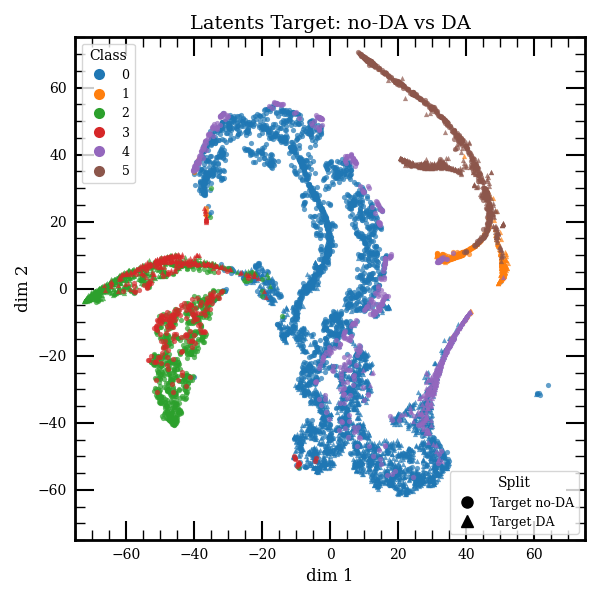

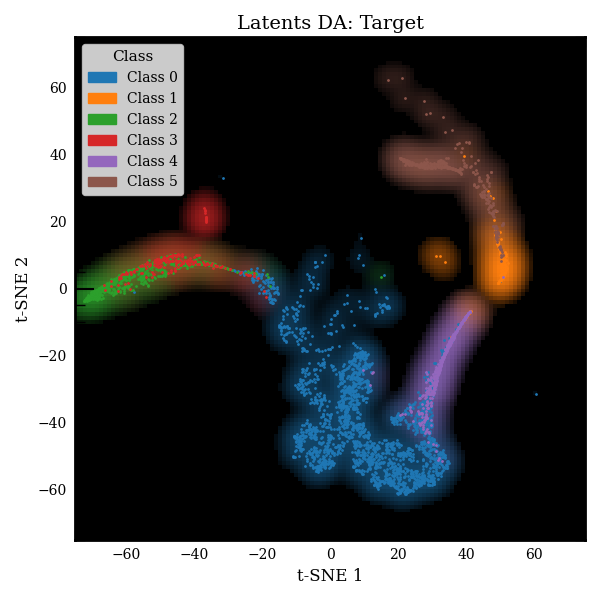

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:957: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7.5, 6.5))


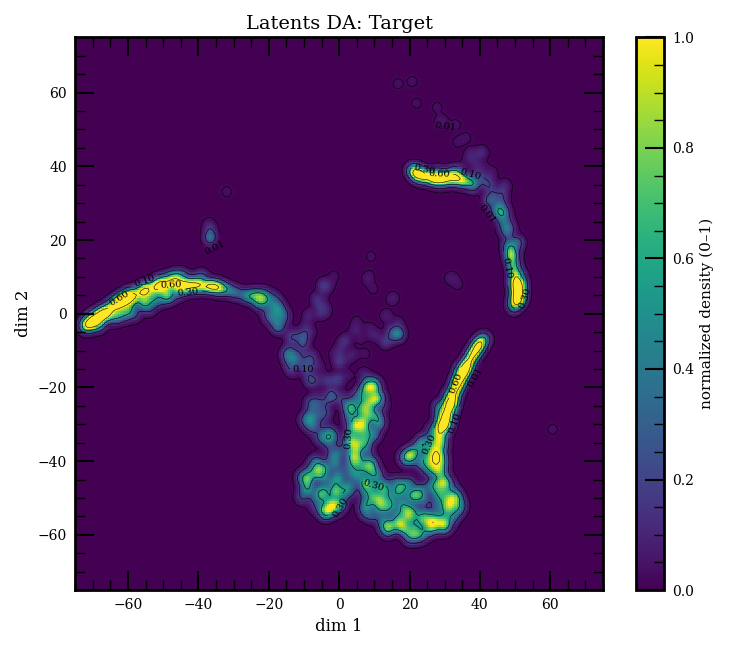

In [10]:
xlim = (-75, 75)
ylim = (-75, 75)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Source_tSNE'], y_val=yy_true_val_no_DA,
    X_test=latents_tSNE['latents_no_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents no-DA: Source vs Target",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Source no-DA",
    legend_split_2="Target no-DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Source_tSNE'], yy_true_val_no_DA,
    class_counts=dset_val_no_DA.class_counts,
    class_names=None,
    title="Latents no-DA: Source",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Source_tSNE'],
    title="Latents no-DA: Source",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Target_tSNE'], yy_true_test,
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents no-DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Target_tSNE'],
    title="Latents no-DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Target_tSNE'], y_val=yy_true_test,
    X_test=latents_tSNE['latents_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents Target: no-DA vs DA",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Target no-DA",
    legend_split_2="Target DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_DA_Target_tSNE'], yy_true_test,
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_DA_Target_tSNE'],
    title="Latents DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)